# Import pakcages

In [5]:
!pip install pyLDAvis

In [6]:
!pip install striprtf

In [7]:
!pip install contractions

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import gensim
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from striprtf.striprtf import rtf_to_text
import re
from collections import Counter
import matplotlib.pyplot as plt
from itertools import chain
import string
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models.phrases import Phrases, Phraser
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import contractions
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models import LdaModel
import random
import seaborn as sns
from gensim.corpora import Dictionary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Testing LDA model on English Modern

# Data preprocessing

### Functions

In [12]:
def get_files(root_dir):
  # Define a list to store the text from .rtf files
  file_list = []

  # Recursively search for files in the root directory and its subdirectories
  for subdir, dirs, files in os.walk(root_dir):
      for fil in files:
          obj = {}
          file_path = os.path.join(subdir, fil)
          seg = subdir.split('/')
          obj['term'] = seg[-1]
          f = open(file_path, 'r')
          text = f.read()
          obj['text'] = text
          f.close
          file_list.append(obj)
  return file_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def extract_doc (file_list):
  regex_pattern = "(.*?)Database:"
  doc_list = []
  for obj in file_list:
    matches = re.finditer(regex_pattern, obj['text'], re.DOTALL)
    for mat in matches:
      doc = {}
      extracted_text = mat.group(1).strip()
      doc['text'] = extracted_text
      doc['term'] = obj['term']
      doc_list.append(doc)
  return doc_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
def extract_full_text(doc_list):
  cont_list = []
  pattern0 = r"Full text:(.*?)Location:"
  pattern1 = r"document ID:(.*?)\n"
  pattern2 = r"Source type:(.*?)\n"
  pattern3 = r"Publication date:(.*?)\n"
  pattern4 = r"^.*?Subject:.*?$"
  pattern5 = r"^.*?Business indexing term:.*?$"
  subject_pattern = r"Subject:(.*?)\n"
  subject = ["NA"]
  source = "NA"
  date = "NA"
  for doc in doc_list:
    t = {}
    m0 = re.search(pattern0, doc['text'], re.DOTALL)
    cont = m0.group(1).strip()
    m1 = re.search(pattern1, doc['text'], re.DOTALL)
    id = m1.group(1).strip()
    m2 = re.search(pattern2, doc['text'], re.DOTALL)
    if m2:
      source = m2.group(1).strip()
    m3 = re.search(pattern3, doc['text'], re.DOTALL)
    if m3:
      date = m3.group(1).strip()
    m6 = re.search(subject_pattern, doc['text'], re.DOTALL)
    if m6:
      subject = m6.group(1).strip()
      subject = subject.split("; ")
    m4 = re.search(pattern4, cont, re.DOTALL)
    m5 = re.search(pattern5, cont, re.DOTALL)
    if m5:
      cont = re.sub(pattern5, "", cont, flags=re.MULTILINE)
    if m4:
      cont = re.sub(pattern4, "", cont, flags=re.MULTILINE)
    t['term'] = doc['term']
    t['full_text'] = cont
    t['date'] = date
    t['source'] = source
    t['id'] = id
    t['subject'] = subject
    file_name = source + "_" + doc['term'] + "_" + date + "_" + id
    print(file_name)
    cont_list.append(t)
  return cont_list



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def rm_duplicates(cont_list):
  unique_data = []
  seen_texts = set()
  for entry in cont_list:
      full_text = entry['full_text'][:100]
      if full_text not in seen_texts:
          unique_data.append(entry)
          seen_texts.add(full_text)
  return unique_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def remove_links(text):
    pattern = r'\( https?://[^\s()]+ \)'
    text_without_links = re.sub(pattern, '', text)
    return text_without_links

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
def rm_contractions (text_list):
  expanded_doc = [contractions.fix(text['full_text']) for text in text_list]
  return expanded_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
def remove_short_and_long_words(nested_list, min_length=3, max_length=15):
    filtered_list = []

    for sublist in nested_list:
        filtered_sublist = [word for word in sublist if min_length <= len(word) <= max_length]
        filtered_list.append(filtered_sublist)

    return filtered_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
def text_clean_punctuation(text_list):
  cleaned_list = []
  for text in text_list:
    cleaned = text.replace('\n', ' ').replace("\\", "").replace(' - ', '-').replace('"', ' ')
    punctuation = string.punctuation.replace('-', '').replace("'",'')
    no_punctuation = cleaned.translate(str.maketrans('', '', punctuation))
    cleaned_list.append(no_punctuation)
  return cleaned_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
def stemming(text_list):
  stemmer = PorterStemmer()
  stemmed_documents = [[stemmer.stem(word) for word in doc] for doc in text_list]
  return stemmed_documents

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
def tokenize_rm_stopwords(text_list):
  stop_words = stopwords.words('english')
  texts = [[word for word in document.lower().split() if word not in stop_words] for document in text_list]
  return texts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
def include_subject(unique_list, tokenized_list):
  result_list = tokenized_doc[:]
  for i in range(len(result_list)-1):
    subject = unique_list[i]['subject']
    subject = [string.lower().replace(" ", "_") for string in subject]
    result_list[i].extend(subject)
  return result_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
def lemmatize_doc(doc):
    lemmatizer = WordNetLemmatizer()
    lemmatized_list = []

    for sublist in doc:
        lemmatized_sublist = []
        i = 0
        for token in sublist:
          # Lemmatize nouns
          for arg in ['n', 'v', 'a', 'r']:
            token = lemmatizer.lemmatize(token, pos=arg)
          lemmatized_sublist.append(token)
        lemmatized_list.append(lemmatized_sublist)
        # for token, lemma in zip(sublist, lemmatized_sublist):
        #   if i < 10:
        #     print(f"{token} --> {lemma}")
        #   else:
        #     break
        #   i += 1
    return lemmatized_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
def add_bigram(lemma_doc, min_count=10):
  bigram = Phrases(lemma_doc, min_count = min_count)
  bigram_doc = [bigram[doc] for doc in lemma_doc]
  return bigram_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
def add_trigram(bigram_doc, min_count=10):
  trigram = Phrases(bigram_doc, min_count = min_count)
  trigram_doc = [trigram[doc] for doc in bigram_doc]
  return trigram_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
def rm_key_term (trigram_doc, word_list):
  result = [[word for word in doc if word not in word_list]for doc in trigram_doc]
  return result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import data

In [27]:
root_dir = '/content/drive/MyDrive/audace_trial/corpus/english_modern'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
file_list = get_files(root_dir)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data cleaning

In [29]:
doc_list = extract_doc(file_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
cont_list = extract_full_text(doc_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Blog, Podcast, or W ebsite_flood_Sep 29, 2020_2447104249
Wire Feed_flood_Sep 28, 2020_2447365132
Blog, Podcast, or W ebsite_flood_Sep 28, 2020_2447063451
Blog, Podcast, or W ebsite_flood_Sep 28, 2020_2447062092
Blog, Podcast, or Website_flood_May 14, 2020_2402597693
Blog, Podcast, or Website_flood_May 8, 2020_2400120923
Blog, Podcast, or Website_flood_Apr 3, 2020_2385834748
Blog, Podcast, or Website_flood_Apr 2, 2020_2385831916
Blog, Podcast, or Website_flood_Apr 2, 2020_2385821376
Blog, Podcast, or Website_flood_Apr 2, 2020_2385757794
Blog, Podcast, or Website_flood_Mar 28, 2020_2383923470
Blog, Podcast, or Website_flood_Mar 13, 2020_2376983539
Newspaper_flood_Feb 12, 2020_2353875312
Blog, Podcast, or Website_flood_Feb 12, 2020_2353761600
Blog, Podcast, or Website_flood_Feb 11, 2020_2353746300
Newspaper_flood_Feb 6, 2020_2351863810
Newspaper_flood_Feb 1, 2020_2349709274
Blog, Podcast, or Website_flood_Jan 31, 2020_2349784146
Blog, Podcast, or Website_flood_Nov 1, 2019_2311264289
Blog,

In [31]:
len(cont_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2737

In [32]:
unique_list = rm_duplicates(cont_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
len(unique_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1559

In [34]:
exp_list = rm_contractions(unique_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
cleaned_content = text_clean_punctuation(exp_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
tokenized_doc = tokenize_rm_stopwords(cleaned_content)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
new_tokenized_doc = include_subject(unique_list, tokenized_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
filtered_doc = remove_short_and_long_words(new_tokenized_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
lemma_doc = lemmatize_doc(filtered_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
# keywords = ['flood', 'blizzard', 'snow', 'heat_wave', 'rain', 'fire', 'heat', 'wave']
# lemma_doc = rm_key_term(lemma_doc, keywords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
bigram_doc = add_bigram(lemma_doc, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
trigram_doc = add_trigram(bigram_doc, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


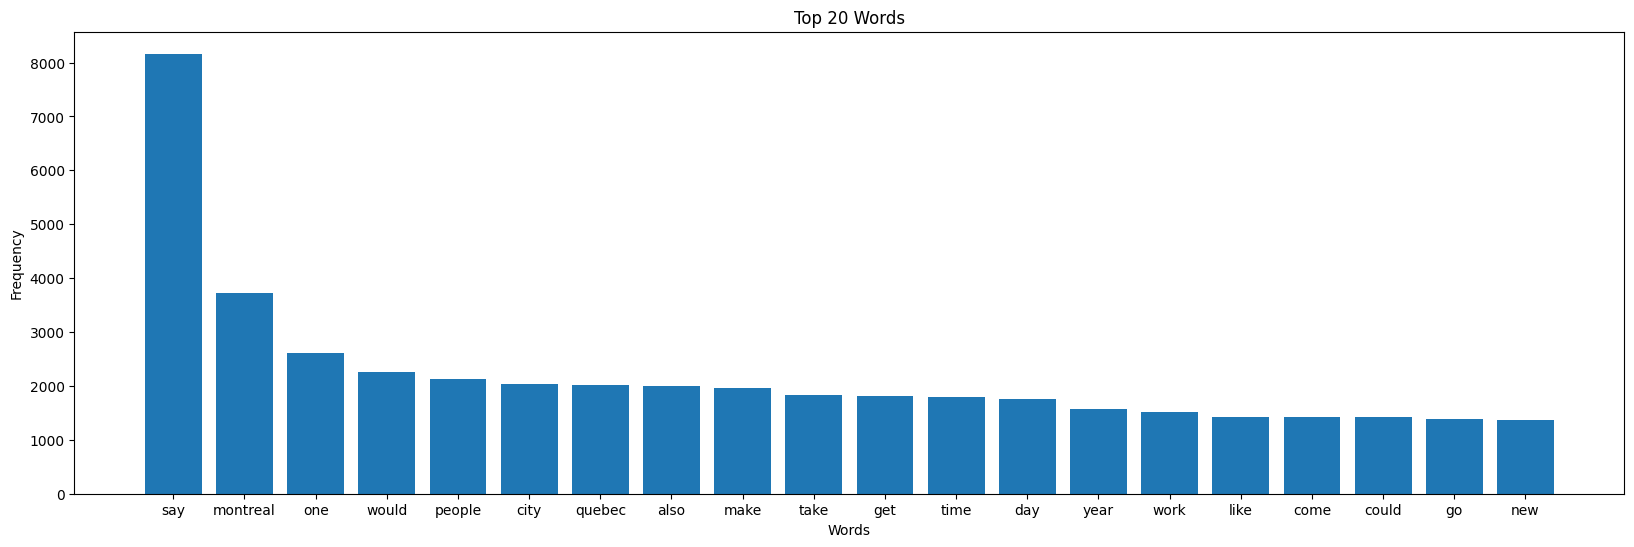

In [43]:
words = trigram_doc

flat_words = list(chain.from_iterable(words))

word_counts = Counter(flat_words)

top_words = word_counts.most_common(20)

labels, values = zip(*top_words)
plt.figure(figsize=(20, 6))
plt.bar(labels, values)
plt.title("Top 20 Words")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.show()

## Create corpus and dictionary

In [44]:
no_below = 20
no_above = 0.5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# Create dictionary and corpus
texts = trigram_doc
dictionary = gensim.corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=no_below, no_above=no_above)
corpus = [dictionary.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3578
Number of documents: 1559


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Genism LDA model

## Select number of topics: K

In [ ]:
chunksize = 2200
passes = 15
iterations = 400
eval_every = None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
max_num = 50

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### cv coherence score

In [ ]:
coherence_scores_cv = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cv.append(coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


number of topics:  1
nCoherence Score:  0.276163800607361
number of topics:  2
nCoherence Score:  0.2893734872371512
number of topics:  3
nCoherence Score:  0.3442757678215758
number of topics:  4
nCoherence Score:  0.32816564205058896
number of topics:  5
nCoherence Score:  0.3337595194484864
number of topics:  6
nCoherence Score:  0.3767535204622409
number of topics:  7
nCoherence Score:  0.33876117040825254
number of topics:  8
nCoherence Score:  0.33069303759219054
number of topics:  9
nCoherence Score:  0.32850290508069735
number of topics:  10
nCoherence Score:  0.37562254476009793
number of topics:  11
nCoherence Score:  0.3361030932109934
number of topics:  12
nCoherence Score:  0.33661338745144237
number of topics:  13
nCoherence Score:  0.38215890724906465
number of topics:  14
nCoherence Score:  0.35690552496042777
number of topics:  15
nCoherence Score:  0.39945763322327904
number of topics:  16
nCoherence Score:  0.36455673707235214
number of topics:  17
nCoherence Score: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


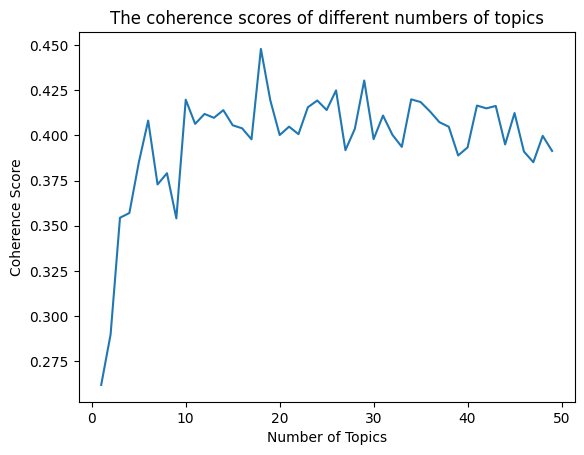

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cv)
plt.title("The coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cv_scores.png")

### umass coherence score

In [ ]:
coherence_scores_umass = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='u_mass')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_umass.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_umass)
plt.title("The umass coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_umass_scores.png")

### c_uci coherence score

In [ ]:
coherence_scores_cuci = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_uci')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cuci.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cuci)
plt.title("The cuci coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cuci_scores.png")

### c_npmi coherence score

In [ ]:
coherence_scores_cnpmi = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_npmi')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cnpmi.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cnpmi)
plt.title("The cnpmi coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cnpmi_scores.png")

### select k

In [ ]:
k = coherence_scores_cv.index(max(coherence_scores_cv))+1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14

## Training

In [ ]:
num_topics = k
chunksize = 2200
passes = 15
iterations = 400
eval_every = None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3578
Number of documents: 1559


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    alpha = 'auto',
    eta = 'auto',
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
coherence_lda = coherence_model_lda.get_coherence()
print("The score is ", coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The score is  0.37855800161931136


In [ ]:
while coherence_lda < 0.45:
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    alpha = 'auto',
    eta = 'auto',
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
  coherence_lda = coherence_model_lda.get_coherence()
  print("The score is ", coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The score is  0.3986049193970081
The score is  0.41152898827757145
The score is  0.38406676447211346
The score is  0.4021648414704885
The score is  0.4143729595229702


KeyboardInterrupt: ignored

In [ ]:
# get the topic-term matrix
topic_terms = lda_model.get_topics()

# number of top words to consider for each topic
topn = 10

# print top words for each topic and assign a label
for i in range(lda_model.num_topics):
    topic_terms_sorted = sorted(enumerate(topic_terms[i]), key=lambda x: x[1], reverse=True)[:topn]
    top_words = [dictionary[id] for id, _ in topic_terms_sorted]
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: rain, expect, area, storm, weather, temperature, region, could, forecast, wind
Topic 2: call, highway, quebec, thursday, city, friday, expect, include, report, monday
Topic 3: people, school, student, parent, city, need, plan, child, new, march
Topic 4: get, like, know, show, go, come, year, think, life, play
Topic 5: company, business, new, build, market, canada, per_cent, canadian, work, cost
Topic 6: heat_wave, city, per_cent, heat, people, temperature, full_story, expect, cool, average
Topic 7: canadiens, game, play, team, season, win, player, get, goal, first
Topic 8: flood, city, home, people, resident, water, fire, area, work, year
Topic 9: quebec, group, people, member, canada, case, show, new, race, call
Topic 10: snow, winter, get, weather, car, city, cold, ski, ice, season
Topic 11: like, restaurant, include, new, food, open, get, park, light, use
Topic 12: park, city, bike, mountain, snow, walk, winter, part, path, use
Topic 13: quebec, liberal, party, vote, govern

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_keywords = lda_model.show_topics(num_topics=-1, num_words=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for topic in topic_keywords:
    print(f"Topic {topic[0]}: {topic[1]}")

Topic 0: 0.019*"rain" + 0.016*"expect" + 0.014*"area" + 0.012*"storm" + 0.012*"weather" + 0.011*"temperature" + 0.010*"region" + 0.010*"could" + 0.010*"forecast" + 0.009*"wind" + 0.008*"quebec" + 0.008*"warn" + 0.008*"friday" + 0.008*"freeze_rain" + 0.007*"environment_canada" + 0.007*"saturday" + 0.007*"sunday" + 0.006*"affect" + 0.006*"power" + 0.006*"even"
Topic 1: 0.012*"call" + 0.011*"highway" + 0.010*"quebec" + 0.008*"thursday" + 0.008*"city" + 0.007*"friday" + 0.007*"expect" + 0.007*"include" + 0.007*"report" + 0.006*"monday" + 0.006*"snow" + 0.005*"begin" + 0.005*"freeze_rain" + 0.005*"tuesday" + 0.004*"wednesday" + 0.004*"service" + 0.004*"rain" + 0.004*"receive" + 0.004*"ave" + 0.004*"close"
Topic 2: 0.011*"people" + 0.010*"school" + 0.007*"student" + 0.006*"parent" + 0.006*"city" + 0.006*"need" + 0.006*"plan" + 0.006*"child" + 0.005*"new" + 0.005*"march" + 0.005*"work" + 0.005*"help" + 0.005*"many" + 0.005*"think" + 0.005*"could" + 0.004*"want" + 0.004*"quebec" + 0.004*"get" 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary,  mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [ ]:
pyLDAvis.save_html(vis_data, 'lda_' + str(k) + 'topics.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Save model

In [ ]:
lda_model.save("/content/drive/MyDrive/audace_trial/model/lda_models/lda_model_include_subject_0.4509_07_02.lda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dictionary.save('/content/drive/MyDrive/audace_trial/model/dictionary/dictionary_2023-07-03_filter_'+ str(no_below) + '_' + str(no_above) +'.dict')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Classification


In [10]:
model = LdaModel.load("/content/drive/MyDrive/audace_trial/model/lda_models/lda_model_include_subject_0.4509_07_02.lda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
vis_data = gensimvis.prepare(model, corpus, dictionary,  mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [48]:
# get the topic-term matrix
topic_terms = model.get_topics()

# number of top words to consider for each topic
topn = 15

# print top words for each topic and assign a label
for i in range(model.num_topics):
    topic_terms_sorted = sorted(enumerate(topic_terms[i]), key=lambda x: x[1], reverse=True)[:topn]
    top_words = [dictionary[id] for id, _ in topic_terms_sorted]
    print(f"Topic {i}: {', '.join(top_words)}")

Topic 0: rain, expect, area, storm, weather, temperature, region, could, forecast, wind, quebec, warn, friday, freeze_rain, environment_canada
Topic 1: call, highway, quebec, thursday, city, friday, expect, include, report, monday, snow, begin, freeze_rain, tuesday, wednesday
Topic 2: people, school, student, parent, city, need, plan, child, new, march, work, help, many, think, could
Topic 3: get, like, know, show, go, come, year, think, life, play, write, people, work, canadian, book
Topic 4: company, business, new, build, market, canada, per_cent, canadian, work, cost, year, yous, people, use, price
Topic 5: heat_wave, city, per_cent, heat, people, temperature, full_story, expect, cool, average, may, report, fire, high, extreme_heat
Topic 6: canadiens, game, play, team, season, win, player, get, goal, first, hockey, best, two, good, go
Topic 7: flood, city, home, people, resident, water, fire, area, work, year, house, river, help, horse, come
Topic 8: quebec, group, people, member, c

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Multiple Label

In [60]:
topic_labels = {
    0: "Weather and Forecasts",
    1: "Winter Road Conditions and Traffic (Vulnerability)",
    2: "Education and School Planning",
    3: "Entertainment",
    4: "Business and Market Trends",
    5: "Heatwave and Extreme Temperatures (Vulnerability)",
    6: "Sports",
    7: "Floods and Home Safety (Vulnerability)",
    8: "Social Issues and Advocacy",
    9: "Winter Road Conditions and Traffic (Vulnerability)",
    10: "Entertainment",
    11: "Entertainment",
    12: "Political Parties and Elections",
    13: "COVID-19 Updates and Response",
    14: "Daily Quotes and Social Media",
    15: "Climate Change and Environmental Impact",
    16: "Sports",
    17: "City Operations and Services in Winter (Vulnearbility)"
    # Add labels for other topics
}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
for topic_id in range(model.num_topics):
    top_words = model.show_topic(topic_id, topn=10)  # Get top 10 words for the topic
    label = topic_labels.get(topic_id, f"Topic {topic_id}")  # Get the label or use default label
    print(f"{label}:")
    for word, prob in top_words:
        print(f"{word}: {prob}")
    print()

Weather and Forecasts:
rain: 0.01886989176273346
expect: 0.016426274552941322
area: 0.014065872877836227
storm: 0.012372586876153946
weather: 0.012351607903838158
temperature: 0.010961799882352352
region: 0.010271086357533932
could: 0.010206353850662708
forecast: 0.010050192475318909
wind: 0.008726381696760654

Winter Road Conditions and Traffic (Vulnerability):
call: 0.011647438630461693
highway: 0.011303354054689407
quebec: 0.009650515392422676
thursday: 0.008370035327970982
city: 0.007518039550632238
friday: 0.007377091329544783
expect: 0.006948912050575018
include: 0.0067143687047064304
report: 0.006515271961688995
monday: 0.006194929592311382

Education and School Planning:
people: 0.010934390127658844
school: 0.010246697813272476
student: 0.007331095170229673
parent: 0.006482355762273073
city: 0.006090788636356592
need: 0.005914338864386082
plan: 0.005828082095831633
child: 0.005582332145422697
new: 0.005462201312184334
march: 0.005198520142585039

Entertainment:
get: 0.007223268

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
topic_distributions = model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    # Sort the topics in descending order of probability
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Retrieve the most probable topic
    most_probable_topic = sorted_topics[0]
    topic_id, topic_prob = most_probable_topic

    # Assign the corresponding topic label to the text based on the topic_id
    topic_label = topic_labels[topic_id]

    print(f"Document {i+1} topic: {topic_label} ({topic_prob})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document 1 topic: Social Issues and Advocacy (0.7523773908615112)
Document 2 topic: Social Issues and Advocacy (0.905031681060791)
Document 3 topic: COVID-19 Updates and Response (0.6724363565444946)
Document 4 topic: COVID-19 Updates and Response (0.41350093483924866)
Document 5 topic: COVID-19 Updates and Response (0.718633770942688)
Document 6 topic: COVID-19 Updates and Response (0.7853976488113403)
Document 7 topic: COVID-19 Updates and Response (0.6737263798713684)
Document 8 topic: COVID-19 Updates and Response (0.46269604563713074)
Document 9 topic: COVID-19 Updates and Response (0.4384622275829315)
Document 10 topic: COVID-19 Updates and Response (0.7670428156852722)
Document 11 topic: Education and School Planning (0.5738961100578308)
Document 12 topic: Education and School Planning (0.5584902167320251)
Document 13 topic: Floods and Home Safety (Vulnerability) (0.7048889994621277)
Document 14 topic: Education and School Planning (0.7155680060386658)
Document 15 topic: Educati

In [64]:
data = []

# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    # Sort the topics in descending order of probability
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Retrieve the most probable topic
    most_probable_topic = sorted_topics[0]
    topic_id, topic_prob = most_probable_topic

    # Assign the corresponding topic label to the text based on the topic_id
    topic_label = topic_labels[topic_id]

    # Retrieve the content of the text from unique_list
    text_content = unique_list[i]['full_text']

    # Append the data to the list
    data.append({'Text': text_content, 'Topic Label': topic_label, 'Probability': topic_prob})

# Create the dataframe
df = pd.DataFrame(data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,Topic Label,Probability
0,QUEBEC - As Quebec health officials scrambled ...,Social Issues and Advocacy,0.752359
1,As Quebec health officials scrambled in late s...,Social Issues and Advocacy,0.905030
2,QUEBEC - The province wants to help Montreal o...,COVID-19 Updates and Response,0.672437
3,Within 48 hours of the provincial government s...,COVID-19 Updates and Response,0.413500
4,Verdun Hospital has been hit with the most sev...,COVID-19 Updates and Response,0.718639
...,...,...,...
1554,Power outages and flight disruptions reported ...,Winter Road Conditions and Traffic (Vulnerabil...,0.402410
1555,? Much of Ontario and large parts of Quebec ar...,Winter Road Conditions and Traffic (Vulnerabil...,0.554470
1556,"Close to 30,000 Quebecers were left without po...",Weather and Forecasts,0.463652
1557,Southern Ontario was hit with a winter storm T...,Winter Road Conditions and Traffic (Vulnerabil...,0.488756


In [69]:
filtered_df = df[df['Topic Label'] != 'Entertainment']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


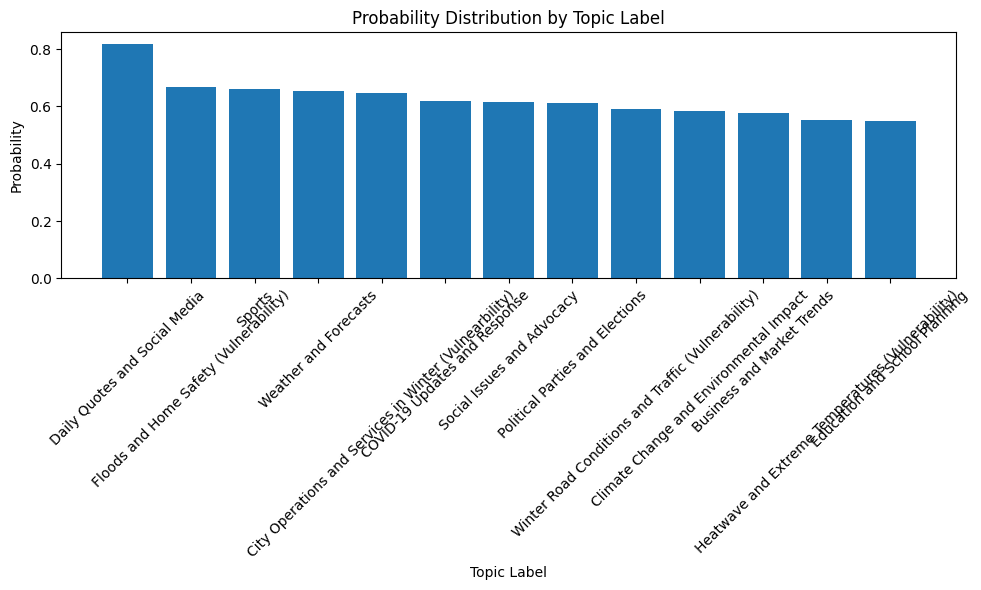

In [74]:
# Group the dataframe by topic label and calculate the mean probability
grouped_df = filtered_df.groupby('Topic Label')['Probability'].mean().reset_index()

# Sort the dataframe by descending probability
grouped_df = grouped_df.sort_values(by='Probability', ascending=False)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['Topic Label'], grouped_df['Probability'])
plt.xlabel('Topic Label')
plt.ylabel('Probability')
plt.title('Probability Distribution by Topic Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


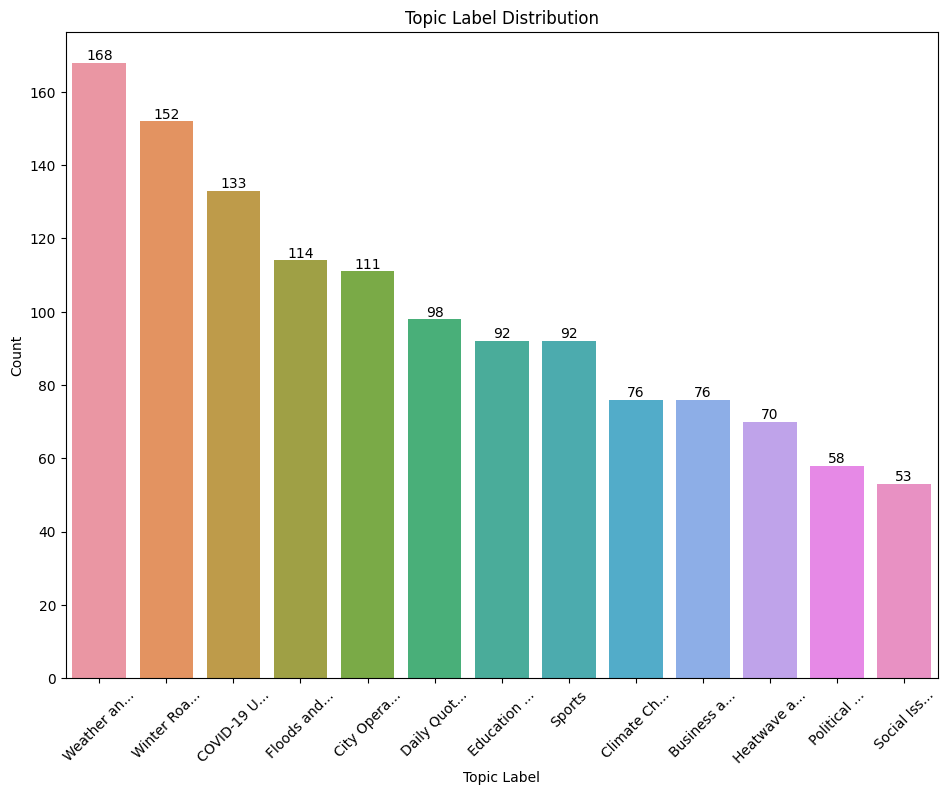

In [75]:
# Count the occurrences of each topic label
label_counts = filtered_df['Topic Label'].value_counts()

plt.figure(figsize=(10, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:10] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### Save dataframe


In [ ]:
df.to_csv('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
df.to_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
filtered_df.to_csv('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023_filtered.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
filtered_df.to_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023_filtered.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Binary Label

In [76]:
topic_labels = {
    0: "neg",
    1: "pos",
    2: "neg",
    3: "neg",
    4: "neg",
    5: "pos",
    6: "neg",
    7: "pos",
    8: "neg",
    9: "pos",
    10: "neg",
    11: "neg",
    12: "neg",
    13: "neg",
    14: "neg",
    15: "neg",
    16: "neg",
    17: "pos"
    # Add labels for other topics
}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
for topic_id in range(model.num_topics):
    top_words = model.show_topic(topic_id, topn=10)  # Get top 10 words for the topic
    label = topic_labels.get(topic_id, f"Topic {topic_id}")  # Get the label or use default label
    print(f"{label}:")
    for word, prob in top_words:
        print(f"{word}: {prob}")
    print()

neg:
rain: 0.01886989176273346
expect: 0.016426274552941322
area: 0.014065872877836227
storm: 0.012372586876153946
weather: 0.012351607903838158
temperature: 0.010961799882352352
region: 0.010271086357533932
could: 0.010206353850662708
forecast: 0.010050192475318909
wind: 0.008726381696760654

pos:
call: 0.011647438630461693
highway: 0.011303354054689407
quebec: 0.009650515392422676
thursday: 0.008370035327970982
city: 0.007518039550632238
friday: 0.007377091329544783
expect: 0.006948912050575018
include: 0.0067143687047064304
report: 0.006515271961688995
monday: 0.006194929592311382

neg:
people: 0.010934390127658844
school: 0.010246697813272476
student: 0.007331095170229673
parent: 0.006482355762273073
city: 0.006090788636356592
need: 0.005914338864386082
plan: 0.005828082095831633
child: 0.005582332145422697
new: 0.005462201312184334
march: 0.005198520142585039

neg:
get: 0.00722326897084713
like: 0.006684588268399239
know: 0.006332491524517536
show: 0.005854696035385132
go: 0.00566

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
topic_distributions = model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    # Sort the topics in descending order of probability
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Retrieve the most probable topic
    most_probable_topic = sorted_topics[0]
    topic_id, topic_prob = most_probable_topic

    # Assign the corresponding topic label to the text based on the topic_id
    topic_label = topic_labels[topic_id]

    print(f"Document {i+1} topic: {topic_label} ({topic_prob})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document 1 topic: neg (0.7523724436759949)
Document 2 topic: neg (0.9050328135490417)
Document 3 topic: neg (0.6724363565444946)
Document 4 topic: neg (0.4134976863861084)
Document 5 topic: neg (0.7186381220817566)
Document 6 topic: neg (0.7853972911834717)
Document 7 topic: neg (0.6737252473831177)
Document 8 topic: neg (0.46266624331474304)
Document 9 topic: neg (0.4384620189666748)
Document 10 topic: neg (0.7670482993125916)
Document 11 topic: neg (0.573904275894165)
Document 12 topic: neg (0.5585302114486694)
Document 13 topic: pos (0.7049230337142944)
Document 14 topic: neg (0.7155534625053406)
Document 15 topic: neg (0.683867871761322)
Document 16 topic: neg (0.8266386389732361)
Document 17 topic: neg (0.7822873592376709)
Document 18 topic: neg (0.26490461826324463)
Document 19 topic: neg (0.9985874891281128)
Document 20 topic: neg (0.996208131313324)
Document 21 topic: neg (0.9993419647216797)
Document 22 topic: neg (0.6293804049491882)
Document 23 topic: pos (0.6537010669708252

In [80]:
data = []

# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    # Sort the topics in descending order of probability
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Retrieve the most probable topic
    most_probable_topic = sorted_topics[0]
    topic_id, topic_prob = most_probable_topic

    # Assign the corresponding topic label to the text based on the topic_id
    topic_label = topic_labels[topic_id]

    # Retrieve the content of the text from unique_list
    text_content = unique_list[i]['full_text']

    # Append the data to the list
    data.append({'Text': text_content, 'Topic Label': topic_label, 'Probability': topic_prob})

# Create the dataframe
df = pd.DataFrame(data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,Topic Label,Probability
0,QUEBEC - As Quebec health officials scrambled ...,neg,0.752367
1,As Quebec health officials scrambled in late s...,neg,0.905029
2,QUEBEC - The province wants to help Montreal o...,neg,0.672439
3,Within 48 hours of the provincial government s...,neg,0.413501
4,Verdun Hospital has been hit with the most sev...,neg,0.718635
...,...,...,...
1554,Power outages and flight disruptions reported ...,pos,0.402425
1555,? Much of Ontario and large parts of Quebec ar...,pos,0.554472
1556,"Close to 30,000 Quebecers were left without po...",neg,0.463640
1557,Southern Ontario was hit with a winter storm T...,pos,0.488597


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


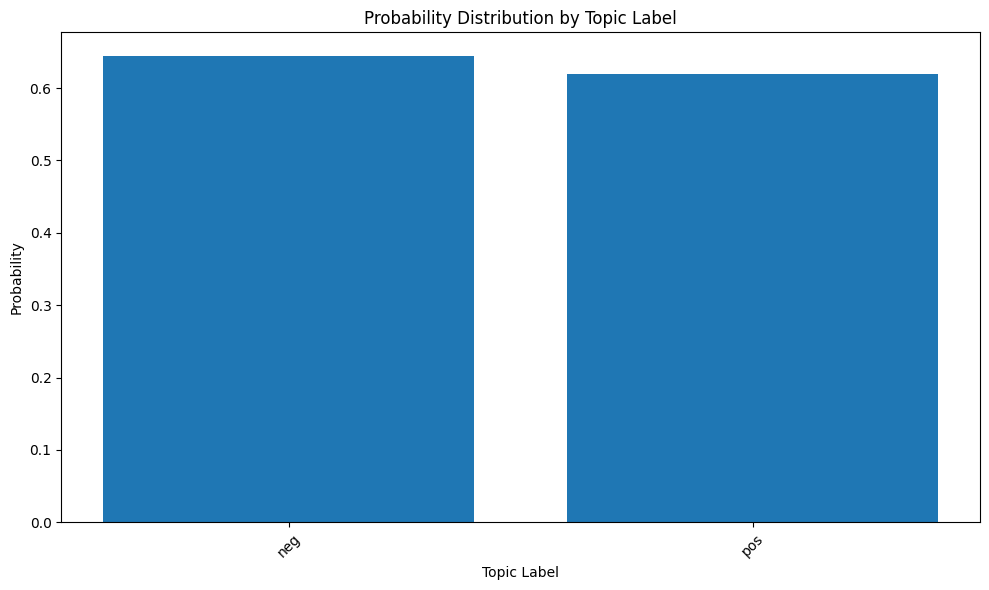

In [82]:
# Group the dataframe by topic label and calculate the mean probability
grouped_df = df.groupby('Topic Label')['Probability'].mean().reset_index()

# Sort the dataframe by descending probability
grouped_df = grouped_df.sort_values(by='Probability', ascending=False)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['Topic Label'], grouped_df['Probability'])
plt.xlabel('Topic Label')
plt.ylabel('Probability')
plt.title('Probability Distribution by Topic Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


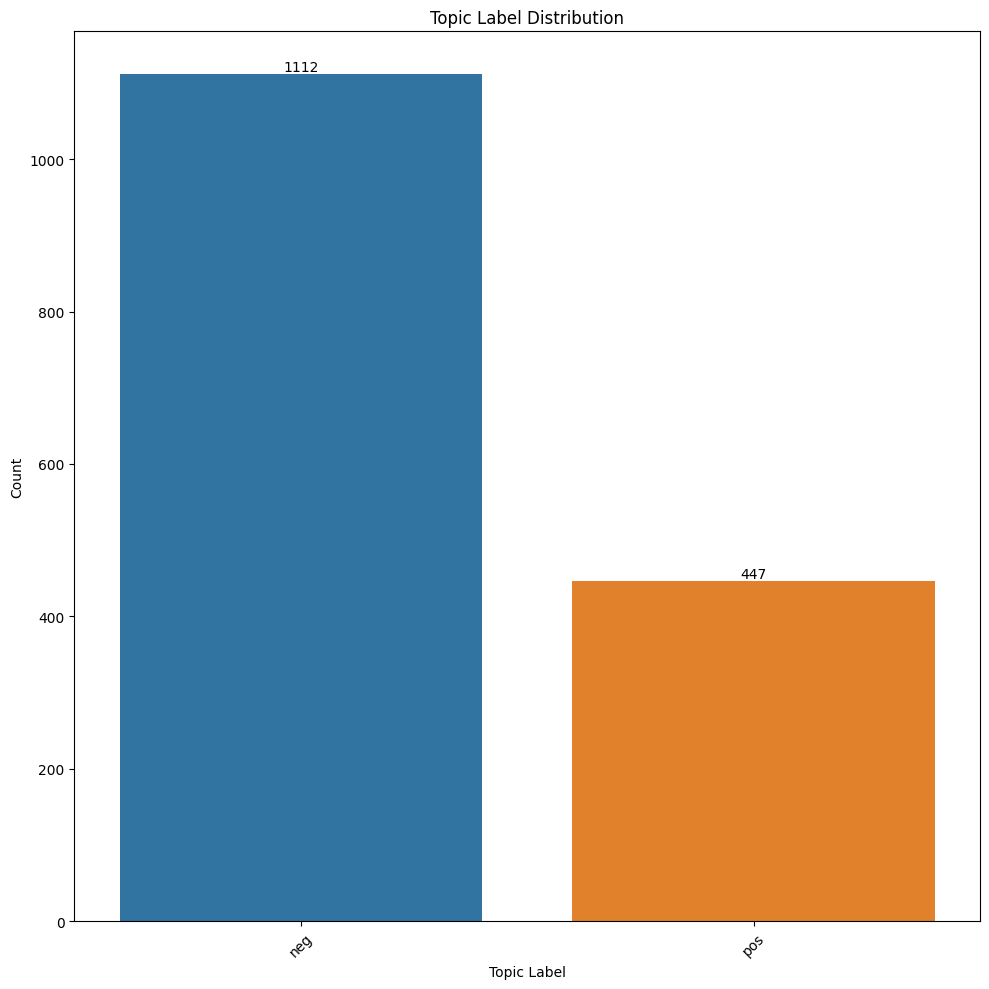

In [83]:
# Count the occurrences of each topic label
label_counts = df['Topic Label'].value_counts()

plt.figure(figsize=(10, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:10] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### Save dataframe

In [84]:
df.to_csv('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023_bi.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
df.to_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023_bi.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Create Validation set based on Subjects

In [ ]:
subject_list = [[s.lower() for s in sublist['subject']] for sublist in unique_list]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
subject_dictionary = gensim.corpora.Dictionary(subject_list)
subject_corpus = [subject_dictionary.doc2bow(subjects) for subjects in subject_list]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Number of unique tokens: %d' % len(subject_dictionary))
print('Number of documents: %d' % len(subject_corpus))

Number of unique tokens: 1276
Number of documents: 1559


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA model on subject

In [ ]:
chunksize = 2200
passes = 15
iterations = 400
eval_every = None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
max_num = 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
subject_coherence_scores_cv = []
for i in range(1, max_num):
  subject_lda_model = gensim.models.LdaModel(
    corpus=subject_corpus,
    id2word=subject_dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  subject_coherence_model_lda = CoherenceModel(model=subject_lda_model, texts=subject_list, corpus=subject_corpus, dictionary=subject_dictionary, coherence='c_v', window_size = 110)
  subject_coherence_lda = subject_coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', subject_coherence_lda)
  subject_coherence_scores_cv.append(subject_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


number of topics:  1
nCoherence Score:  0.25557388035671946
number of topics:  2
nCoherence Score:  0.4596295412089575
number of topics:  3
nCoherence Score:  0.4248601380633215
number of topics:  4
nCoherence Score:  0.5071968895483276
number of topics:  5
nCoherence Score:  0.5005847952005855
number of topics:  6
nCoherence Score:  0.5028415443194015
number of topics:  7
nCoherence Score:  0.47351515608282885
number of topics:  8
nCoherence Score:  0.5011357827938778
number of topics:  9
nCoherence Score:  0.48791568133334107
number of topics:  10
nCoherence Score:  0.5004785630533782
number of topics:  11
nCoherence Score:  0.5333797591951015
number of topics:  12
nCoherence Score:  0.5237958250292077
number of topics:  13
nCoherence Score:  0.4837324362279058
number of topics:  14
nCoherence Score:  0.5251142365211815
number of topics:  15
nCoherence Score:  0.5058295907197727
number of topics:  16
nCoherence Score:  0.5207135440173972
number of topics:  17
nCoherence Score:  0.525

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


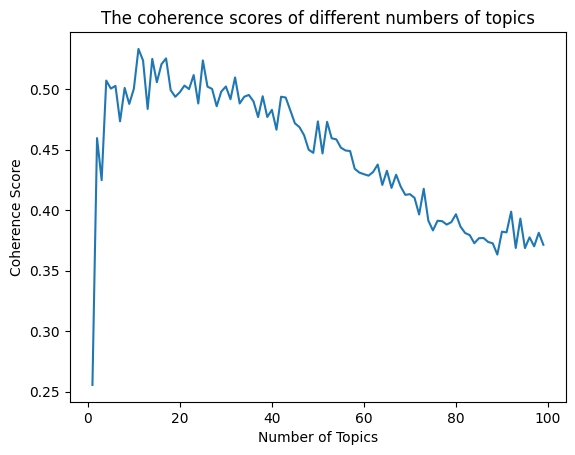

In [ ]:
plt.plot(range(1,max_num), subject_coherence_scores_cv)
plt.title("The coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cv_scores.png")

In [ ]:
subject_coherence_scores_umass = []
for i in range(1, max_num):
  subject_lda_model = gensim.models.LdaModel(
    corpus=subject_corpus,
    id2word=subject_dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  subject_coherence_model_lda = CoherenceModel(model=subject_lda_model, texts=subject_list, corpus=subject_corpus, dictionary=subject_dictionary, coherence='u_mass')
  subject_coherence_lda = subject_coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', subject_coherence_lda)
  subject_coherence_scores_umass.append(subject_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


number of topics:  1
nCoherence Score:  -9.504023275954067
number of topics:  2
nCoherence Score:  -12.822203509810576
number of topics:  3
nCoherence Score:  -11.607446704897
number of topics:  4
nCoherence Score:  -11.776308824767279
number of topics:  5
nCoherence Score:  -13.290730277241071
number of topics:  6
nCoherence Score:  -14.290432229874378
number of topics:  7
nCoherence Score:  -13.934778877949181
number of topics:  8
nCoherence Score:  -14.75778816878217
number of topics:  9
nCoherence Score:  -14.69338023209236
number of topics:  10
nCoherence Score:  -14.837957348095795
number of topics:  11
nCoherence Score:  -14.75016275640753
number of topics:  12
nCoherence Score:  -15.062510596715706
number of topics:  13
nCoherence Score:  -15.954353842281574
number of topics:  14
nCoherence Score:  -15.587786127770334
number of topics:  15
nCoherence Score:  -15.899915475825564
number of topics:  16
nCoherence Score:  -16.234260718372113
number of topics:  17
nCoherence Score: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


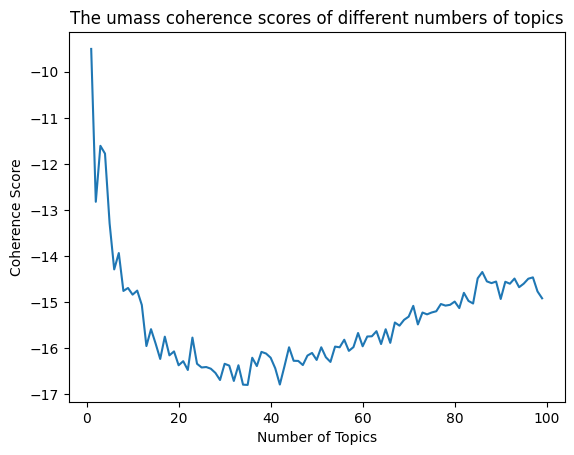

In [ ]:
plt.plot(range(1,max_num), subject_coherence_scores_umass)
plt.title("The umass coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_umass_scores.png")

## Training

In [ ]:
num_topics = 18
chunksize = 2200
passes = 15
iterations = 400
eval_every = None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Number of unique tokens: %d' % len(subject_dictionary))
print('Number of documents: %d' % len(subject_corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
subject_lda_model = gensim.models.LdaModel(
    corpus=subject_corpus,
    id2word=subject_dictionary,
    alpha = 'auto',
    eta = 'auto',
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
subject_coherence_model_lda = CoherenceModel(model=subject_lda_model, texts=subject_list, corpus=subject_corpus, dictionary=subject_dictionary, coherence='c_v', window_size = 110)
subject_coherence_lda = subject_coherence_model_lda.get_coherence()
print("The score is ", subject_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The score is  0.476511101810676


In [ ]:
while subject_coherence_lda < 0.55:
  subject_lda_model = gensim.models.LdaModel(
    corpus=subject_corpus,
    id2word=subject_dictionary,
    alpha = 'auto',
    eta = 'auto',
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )
  subject_coherence_model_lda = CoherenceModel(model=subject_lda_model, texts=subject_list, corpus=subject_corpus, dictionary=subject_dictionary, coherence='c_v', window_size = 110)
  subject_coherence_lda = subject_coherence_model_lda.get_coherence()
  print("The score is ", subject_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The score is  0.5050230387720551
The score is  0.5237889359561575
The score is  0.515949282362476
The score is  0.5000157443384837
The score is  0.5013914299122322
The score is  0.5052249248575588
The score is  0.48319356166216104
The score is  0.5246868043338303
The score is  0.5236151035438763
The score is  0.5316855508002695
The score is  0.5086293676740561
The score is  0.4890808096821537
The score is  0.5212162350531538
The score is  0.5145926287495635
The score is  0.5260908862195067
The score is  0.516567594260623
The score is  0.5001091884165808
The score is  0.5214196798665964
The score is  0.5026114191477657
The score is  0.4846281525836197
The score is  0.5277751481003284
The score is  0.4915291743592864
The score is  0.49898600777777563
The score is  0.5306107583099748
The score is  0.4641451853860682
The score is  0.5062879873079809
The score is  0.5349602637809716
The score is  0.4836926349018635
The score is  0.5088617147147413
The score is  0.5133920641494996
The score 

In [ ]:
# get the topic-term matrix
topic_terms = subject_lda_model.get_topics()

# number of top words to consider for each topic
topn = 10

# print top words for each topic and assign a label
for i in range(subject_lda_model.num_topics):
    topic_terms_sorted = sorted(enumerate(topic_terms[i]), key=lambda x: x[1], reverse=True)[:topn]
    top_words = [dictionary[id] for id, _ in topic_terms_sorted]
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: rest_canada, guideline, country, happen, second, coverage, day, half, frighten_help_dedicate, rather
Topic 2: frighten_help_dedicate, spring, dangerous, sick, moment, plante, classroom, case_covid-19, covid-19_case, work_hard
Topic 3: quebec_city, dedicate_local_covid-19_coverage, start, learn, clean, become_increasingly, centre, necessarily, covid-19_case, continue_rise
Topic 4: measure, communicate, relate, target, action, may, two, ear, much, certainly
Topic 5: concede, steep, sick, file, make_decision, ban, canada's, tell_montreal_gazette, change, lift
Topic 6: sick, national_assembly, staff, certainly, second, add, die, despite, moment, disease
Topic 7: disease, expose, brief, also, still, express, relation, freedom, result, picture
Topic 8: abandon, 10000, actively, add, able, collection, response, organize, covid-19_death, second
Topic 9: certainly, quebec_city, clear_whether, disease, interview, careful, government's_decision, possibility, hour, population
Topic 10: da

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_keywords = subject_lda_model.show_topics(num_topics=-1, num_words=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for topic in topic_keywords:
    print(f"Topic {topic[0]}: {topic[1]}")

Topic 0: 0.061*"winter" + 0.028*"musical performances" + 0.024*"automobile drivers" + 0.022*"singers" + 0.021*"air conditioning" + 0.021*"emergency medical care" + 0.020*"roads & highways" + 0.017*"musicians & conductors" + 0.017*"snow removal" + 0.015*"traffic congestion" + 0.014*"social networks" + 0.014*"heat" + 0.013*"musical recordings" + 0.013*"airports" + 0.011*"bands" + 0.011*"schools" + 0.010*"festivals" + 0.010*"theater" + 0.010*"wetlands" + 0.010*"bicycling"
Topic 1: 0.140*"snow removal" + 0.062*"ice" + 0.043*"rain" + 0.038*"heat" + 0.034*"humidity" + 0.029*"walkways" + 0.023*"cities" + 0.023*"school boards" + 0.011*"customer services" + 0.010*"holidays & special occasions" + 0.008*"older people" + 0.008*"chronic obstructive pulmonary disease" + 0.008*"composting" + 0.008*"recycling" + 0.008*"music festivals" + 0.008*"elections" + 0.007*"cold" + 0.007*"restaurants" + 0.007*"journalism" + 0.007*"computers"
Topic 2: 0.077*"professional hockey" + 0.032*"storm damage" + 0.031*"t

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vis_data = gensimvis.prepare(subject_lda_model, subject_corpus, subject_dictionary,  mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [ ]:
pyLDAvis.save_html(vis_data, 'lda_' + str(11) + 'topics.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
subject_lda_model.save("/content/drive/MyDrive/audace_trial/model/lda_models/lda_model_subject_0.5509_07_04.lda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
